### **Importing libraries and setup**

In [1]:
import tensorflow as tf
from tensorflow import keras  
from tensorflow.keras import layers 
import numpy as np
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img


### ***Import Dataet either loading raw dataset or by downloading***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Loadind dataset from drive**

In [3]:
!unzip -q '/content/drive/MyDrive/Dataset/Fruits_Dataset.v1-resize-512x512-reflect.folder.zip' 

replace train/Tomato 4/59_100_jpg.rf.01f240cf6cf83e9a30b6a2ad5521dc26.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### **Checking Classes**

In [4]:
!ls train

'Tomato 3'  'Tomato Cherry Red'  'Tomato Yellow'
'Tomato 4'  'Tomato Maroon'	  Walnut


### **Creatind database by dividing the data into validation and training dataset**

In [5]:
image_size = (512, 512)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 2909 files belonging to 6 classes.
Using 2328 files for training.
Found 2909 files belonging to 6 classes.
Using 581 files for validation.


### **Viualization of Dataset**

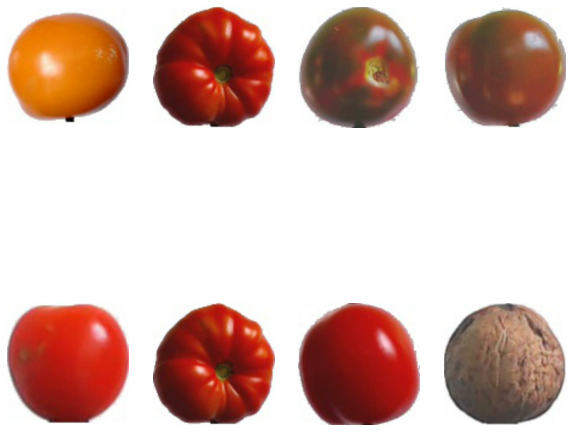

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images, label in train_ds.take(1):
 for i in range(8):
  ax= plt.subplot(2,4,i+1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.axis("off")

### **Data augmentation**

In [7]:
data_augmen = keras.Sequential(
   [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
   ] 
)

### **Viualization of Data augmeatation of database**

In [ ]:
plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
  for i in range(20):
    aug_images=data_augmen(images)
    ax=plt.subplot(4,5,i+1)
    plt.imshow(aug_images[2].numpy().astype("uint8"))

### **Configure dataset performance**

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

### **Building a model**

In [ ]:
def make_model(input_shape,num_classes):
  inputs=keras.Input(shape=input_shape)
  x=data_augmen(inputs)
  x=layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
  x=layers.Conv2D(32,3,strides=2,padding="same")(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  x=layers.Conv2D(64,3,padding="same")(x)
  x=layers.BatchNormalization()(x)
  x=layers.Activation("relu")(x)

  prev_blk_residual=x

  for size in [128, 256, 512, 728]:

      x=layers.Activation("relu")(x)
      x=layers.SeparableConv2D(size,3,padding="same")(x)
      x=layers.BatchNormalization()(x)

      x=layers.Activation("relu")(x)
      x=layers.SeparableConv2D(size,3,padding="same")(x)
      x=layers.BatchNormalization()(x)

      x=layers.MaxPooling2D(3,strides=2,padding="same")(x)


      res=layers.Conv2D(size,3,strides=2,padding="same")(prev_blk_residual)

      x=layers.add([x,res])
      prev_blk_residual=x

      x=layers.SeparableConv2D(1024,3,padding="same")(x)
      x=layers.BatchNormalization()(x)
      x=layers.Activation("relu")(x)

      x=layers.GlobalAveragePooling2D()(x)

      if num_classes == 2:
          activation="sigmoid"
          units=1;
      else:
          activation="softmax"
          units=num_classes

      x=layers.Dropout(0.5)(x)
      outputs=layers.Dense(units,activation=activation)(x)
      return keras.Model(inputs,outputs)
      
model=make_model(input_shape=image_size+(3,),num_classes=6)
keras.utils.plot_model(model,show_shapes=True)






### **Training of Model**

In [11]:
epochs=5

callbacks=[
           keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
291/291 [==============================] - 142s 473ms/step - loss: 0.4423 - accuracy: 0.8254 - val_loss: 1.3863 - val_accuracy: 0.5869
Epoch 2/5
291/291 [==============================] - 136s 468ms/step - loss: 0.1055 - accuracy: 0.9651 - val_loss: 0.0305 - val_accuracy: 0.9914
Epoch 3/5
291/291 [==============================] - 136s 467ms/step - loss: 0.0528 - accuracy: 0.9805 - val_loss: 0.6192 - val_accuracy: 0.8141
Epoch 4/5
291/291 [==============================] - 137s 469ms/step - loss: 0.0821 - accuracy: 0.9740 - val_loss: 0.0103 - val_accuracy: 1.0000
Epoch 5/5
291/291 [==============================] - 136s 468ms/step - loss: 0.0351 - accuracy: 0.9875 - val_loss: 0.2869 - val_accuracy: 0.8812


In [12]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Dataset/Fruits_Dataset.v1-resize-512x512-reflect.folder/my_model.h5')  # creates a HDF5 file 'my_model.h5'


### **Printing and testing of random images**

In [14]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Dataset/Fruits_Dataset.v1-resize-512x512-reflect.folder/Test_images/Cherry Tamto.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
np.shape(score)
print("Tomat3: %.3f and Tomat4: %.3f and Cherry Tomato: %.3f and Maroon Tomato: %.3f and Yellow Tomato: %.3f and walnut: %.3f" % (score[0],score[1],score[2],score[3],score[4],score[5]))


Tomat3: 0.001 and Tomat4: 0.000 and Cherry Tomato: 0.999 and Maroon Tomato: 0.000 and Yellow Tomato: 0.000 and walnut: 0.000
